In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold



In [3]:
# read dataframe
combined = pd.read_pickle('../combined')

# Train a SVM model 

In [26]:
# remove NaN in output antibiotics
def noNullAntibiotics(antibiotics):
    df = combined.loc[pd.isnull(combined[antibiotics + '_ris']) == 0]
    return df

# plot_learning_curve from sklearn examples
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    #return plt

# a simple svm
def trainSVM(df, antibiotics):
    # split test, train
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :406], df[antibiotics + '_ris'], test_size=0.8, random_state=0)
    
    # choose estimator (our model)
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    # cross validation
    skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
    cv = skf.split(X_train, y_train)
   
    # tune hyperparameters
    gammas = np.logspace(-6, -1, 10)
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': gammas,
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    classifier = GridSearchCV(estimator=clf, cv=cv, param_grid=tuned_parameters)
    classifier.fit(X_train.values, np.asarray(y_train))
    
    # print rankings
    rankDf = pd.DataFrame.from_dict(classifier.cv_results_)
    rankDf = rankDf.sort_values('rank_test_score')
    print(rankDf.head())
    
    # plot learning curve
    title = antibiotics +' Learning Curves ' 
    estimator = svm.SVC(kernel='linear', gamma=classifier.best_estimator_.gamma) #put the best parameters in
    plot_learning_curve(estimator, title, X_train.values, np.asarray(y_train), cv=skf)
    plt.show()
    # final evaluation with out test set: default: accuracy
    print('best params:', classifier.best_params_, 'best scorer', classifier.scorer_, 'best gamma', classifier.best_estimator_.gamma)
    print('classifier score', classifier.score(X_test, y_test))
    

# combine everything
def antiToSVM(antibiotics):
    df = noNullAntibiotics(antibiotics)
    trainSVM(df, antibiotics)
    

/home/hermuba/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


    mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
43       0.000892         0.000412         0.924528          0.981467    1000   
36       0.001007         0.000417         0.924528          0.981467    1000   
37       0.000974         0.000420         0.924528          0.981467    1000   
42       0.000967         0.000493         0.924528          0.981467     100   
41       0.000891         0.000399         0.924528          0.981467      10   

   param_gamma param_kernel  \
43         NaN       linear   
36  0.00215443          rbf   
37  0.00774264          rbf   
42         NaN       linear   
41         NaN       linear   

                                               params  rank_test_score  \
43                    {'C': 1000, 'kernel': 'linear'}                1   
36  {'C': 1000, 'gamma': 0.00215443469003, 'kernel...                1   
37  {'C': 1000, 'gamma': 0.00774263682681, 'kernel...                1   
42                     {'C': 1

/home/hermuba/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


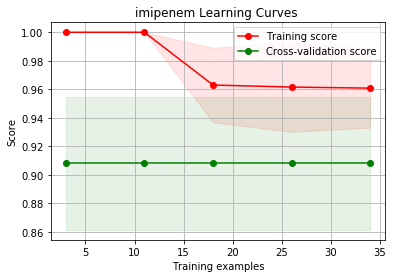

best params: {'C': 1000, 'gamma': 0.0021544346900318843, 'kernel': 'rbf'} best scorer <function _passthrough_scorer at 0x7fab40cdc840> best gamma 0.00215443469003
classifier score 0.874418604651


In [27]:
antiToSVM('imipenem')

In [10]:
combined['imipenem_ris'].value_counts()

R     149
S     114
I       5
Name: imipenem_ris, dtype: int64

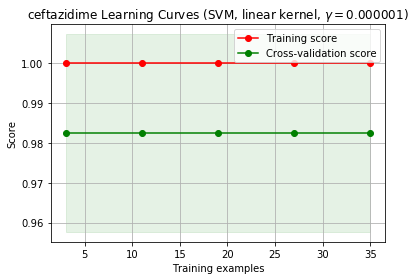

classifier score 0.926605504587


In [11]:
antiToSVM('ceftazidime')

/home/hermuba/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/hermuba/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


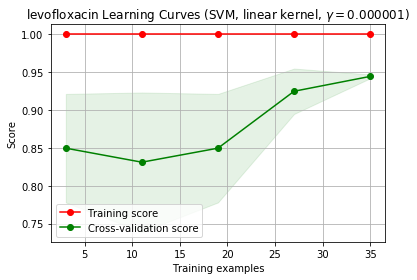

classifier score 0.916666666667


In [12]:
antiToSVM('levofloxacin')

In [ ]:
combined['levofloxacin_ris'].value_counts()

In [ ]:
antiToSVM('ciprofloxacin')

## interpretation:

the learning vurve suggesting high variance
[reference](https://drive.google.com/drive/folders/0BweONCgBYqEqeHkyT1MwZjF4UUE)

# try SVM kernal: rbf

In [5]:
np.logspace(-6, -1, 10)

array([  1.00000000e-06,   3.59381366e-06,   1.29154967e-05,
         4.64158883e-05,   1.66810054e-04,   5.99484250e-04,
         2.15443469e-03,   7.74263683e-03,   2.78255940e-02,
         1.00000000e-01])

In [5]:
# remove NaN in output antibiotics
def noNullAntibiotics(antibiotics):
    df = combined.loc[pd.isnull(combined[antibiotics + '_ris']) == 0]
    return df

# plot_learning_curve from sklearn examples
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    #return plt

# a simple svm
def trainSVMrbf(df, antibiotics):
    # split test, train
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :406], df[antibiotics + '_ris'], test_size=0.8, random_state=0)
    
    # choose estimator (our model)
    clf = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train)
    # cross validation
    skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
    cv = skf.split(X_train, y_train)
   
    # tune hyperparameters
    gammas = np.logspace(-6, -1, 10)
    classifier = GridSearchCV(estimator=clf, cv=cv, param_grid=dict(gamma=gammas))
    classifier.fit(X_train.values, np.asarray(y_train))
    
    # plot learning curve
    title = antibiotics +' Learning Curves (SVM, rbf kernel, $\gamma=%.6f$)' %classifier.best_estimator_.gamma
    estimator = svm.SVC(kernel='linear', gamma=classifier.best_estimator_.gamma) #put the best parameters in
    plot_learning_curve(estimator, title, X_train.values, np.asarray(y_train), cv=skf)
    plt.show()
    # final evaluation with out test set: default: accuracy
    print('classifier score', classifier.score(X_test, y_test))
    

# combine everything
def antiToSVMrbf(antibiotics):
    df = noNullAntibiotics(antibiotics)
    trainSVMrbf(df, antibiotics)

/home/hermuba/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/hermuba/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


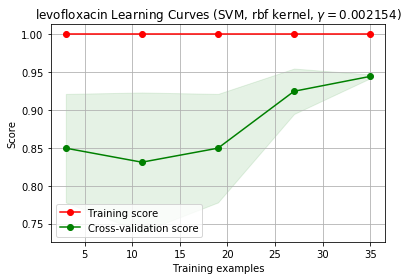

classifier score 0.861111111111


In [7]:
antiToSVMrbf('levofloxacin')